In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from ipyleaflet import Map, Marker, MarkerCluster
from IPython.display import display, Markdown

In [44]:
#Reading and Cleaning Data
acled_data = pd.read_csv('./ACLED_DATA_PREVIOUSYEAR.csv') 
gdf = gpd.GeoDataFrame(
    acled_data, geometry=gpd.points_from_xy(acled_data.longitude, acled_data.latitude), crs="EPSG:4326"
)
filtered_gdf = gdf[gdf['fatalities']>0]
ua = gpd.read_file("./ua.json")
roads = gpd.read_file("./Ukraine_-_roads/Ukraine_-_roads.shp")
roads.to_crs("EPSG:4326")


,FID,MED_DESCRI,RTT_DESCRI,F_CODE_DES,ISO,ISOCOUNTRY,Shape__Len,geometry
0,1,Unknown,Unknown,Road,UKR,UKRAINE,39558.773041,"LINESTRING (38.58720 49.09414, 38.58469 49.086..."
1,2,Unknown,Unknown,Road,UKR,UKRAINE,7772.898511,"LINESTRING (26.93383 49.08428, 26.93942 49.091..."
2,3,Without Median,Secondary Route,Road,UKR,UKRAINE,32925.829008,"LINESTRING (30.94397 49.08350, 30.93869 49.084..."
3,4,Without Median,Secondary Route,Road,UKR,UKRAINE,12410.778666,"LINESTRING (38.82147 49.08294, 38.82214 49.113..."
4,5,Without Median,Secondary Route,Road,UKR,UKRAINE,17061.784837,"LINESTRING (33.77845 49.17197, 33.76989 49.169..."
...,...,...,...,...,...,...,...,...
6790,6791,Without Median,Primary Route,Road,UKR,NaN,121.576594,"LINESTRING (26.80669 48.25084, 26.80674 48.25011)"
6791,6792,Without Median,Primary Route,Road,UKR,NaN,1752.601947,"LINESTRING (22.87774 47.98843, 22.86856 47.97987)"
6792,6793,Without Median,Primary Route,Road,UKR,NaN,2261.958812,"LINESTRING (28.37478 45.52785, 28.36043 45.51777)"
6793,6794,Without Median,Primary Route,Road,UKR,NaN,3325.456951,"LINESTRING (28.35388 45.51840, 28.35128 45.524..."


<Axes: >

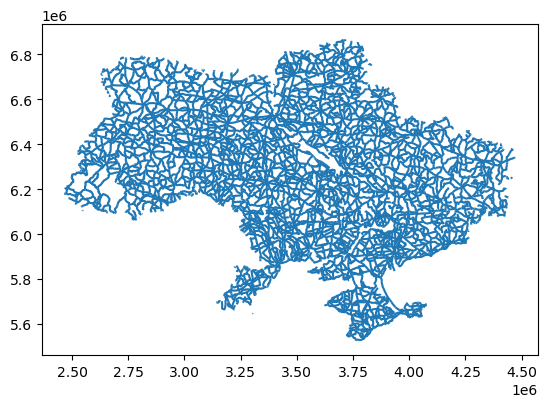

In [11]:
roads.plot()

In [ ]:
def maximum_coverage(demand_points, facility_locations, num_facilities, service_radius):
    """
    Implements the maximum coverage algorithm.

    Args:
        demand_points: GeoDataFrame with demand points.
        facility_locations: GeoDataFrame with candidate facility locations.
        num_facilities: Number of facilities to select.
        service_radius: Service radius around each facility.

    Returns:
        GeoDataFrame of selected facilities.
    """

    selected_facilities = []
    covered_demand = []

    for _ in range(num_facilities):
        max_coverage = 0
        best_facility = None

        for _, facility in facility_locations.iterrows():
            if facility.geometry in selected_facilities:
                continue

            service_area = facility.geometry.buffer(service_radius)
            covered = demand_points[demand_points.geometry.within(service_area)]
            coverage = covered.shape[0]

            if coverage > max_coverage:
                max_coverage = coverage
                best_facility = facility

        if best_facility is not None:
            selected_facilities.append(best_facility.geometry)
            covered_demand.extend(covered_demand)

    return gpd.GeoDataFrame(geometry=selected_facilities, crs="EPSG:4326")

Total points: 6795


<Axes: title={'center': '1 Point per road'}>

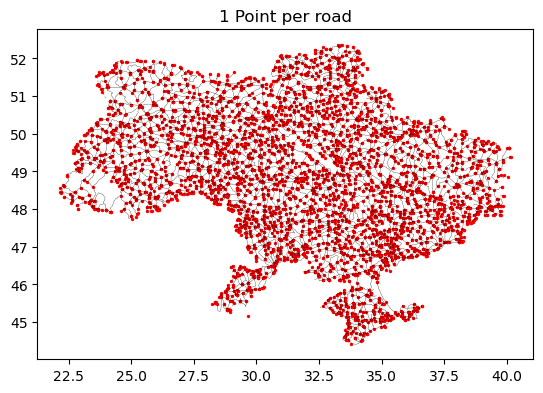

In [32]:
points = []

for index, row in roads.to_crs(filtered_gdf.crs).iterrows():    
    distances = np.linspace(0, row['geometry'].length, 1)
    points.extend([row['geometry'].interpolate(distance) for distance in distances])

print("Total points: " + str(len(points)))

points_gdf = gpd.GeoDataFrame({'geometry': points})

f, ax = plt.subplots()
ax.title.set_text("1 Point per road")
points_gdf.plot(ax=ax, markersize=2, color="RED")
roads.to_crs(filtered_gdf.crs).plot(ax=ax,linewidth=0.2, edgecolor='black')

<Axes: title={'center': 'maximum coverage points'}>

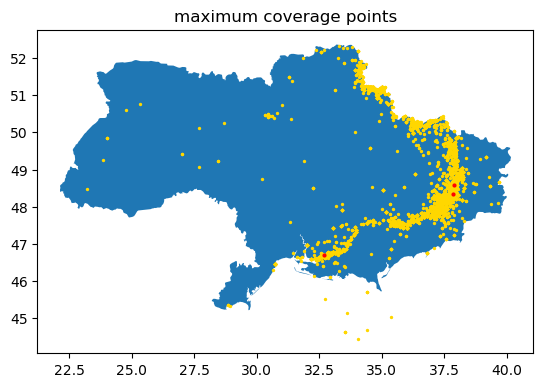

In [60]:
places = maximum_coverage(filtered_gdf, points_gdf, 3, .1) # .05 for the service_radius is a radius of ~5km

f, ax = plt.subplots()
ax.title.set_text("maximum coverage points")
ua.plot(ax=ax)
filtered_gdf.plot(ax=ax, color="gold", markersize=2)
places.to_crs(ua.crs).plot(ax=ax, color="red", markersize=4)

In [61]:
import folium
from folium.plugins import HeatMap

m = folium.Map()

# Extract latitude and longitude from the geometry column
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in filtered_gdf.geometry]

# Add the heatmap layer
HeatMap(heat_data).add_to(m)

# Add the GeoDataFrame to the map
folium.GeoJson(places).add_to(m)

m

KeyboardInterrupt: 

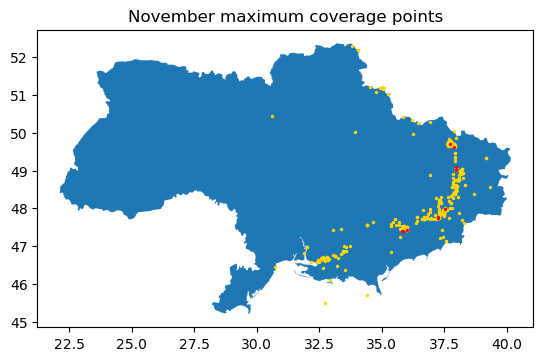

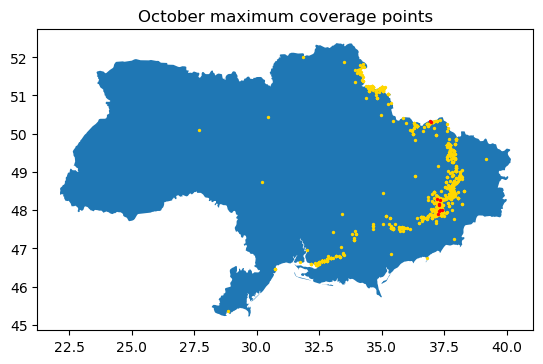

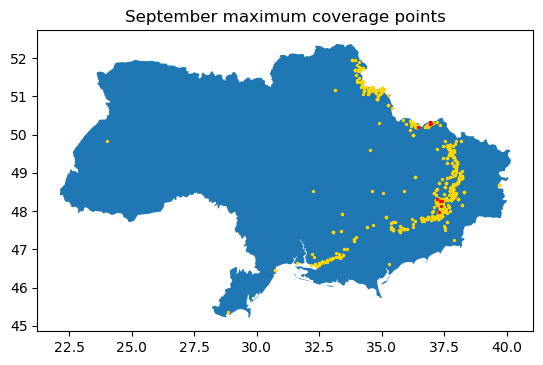

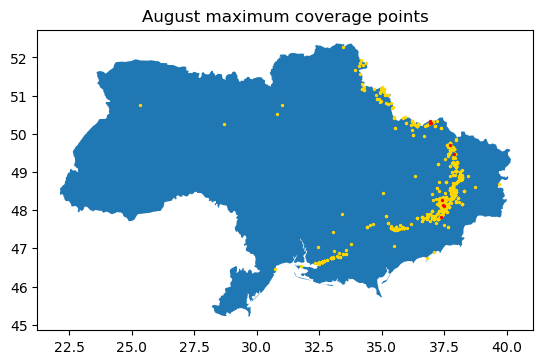

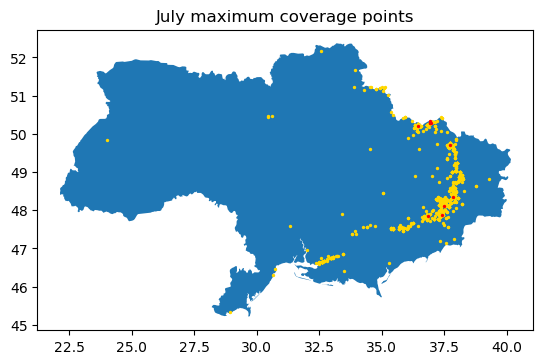

In [46]:
months = ["November","October","September","August","July","June","May","April","March","February","January","December"]

for month in months:
    places = maximum_coverage(filtered_gdf[filtered_gdf['event_date'].str.contains(month)], points_gdf, 10, .05) # .05 for the service_radius is a radius of ~5km

    f, ax = plt.subplots()
    ax.title.set_text(month + " maximum coverage points")
    ua.plot(ax=ax)
    filtered_gdf[filtered_gdf['event_date'].str.contains(month)].plot(ax=ax, color="gold", markersize=2)
    places.to_crs(ua.crs).plot(ax=ax, color="red", markersize=2)